In [1]:
from model import Dense, Rough
from losses.Loss import MSE
from Controller import NINC_close_loop, NINC_plant
from model import Online_NN_section
from utils import randomized_pulse_generator
import numpy as np

## Define state space modeling

In [2]:
def states(t, state, input):
    dydt = state * 0
    dydt[0] = 2 * state[1] + 0.9 * input[1]
    dydt[1] = -3 * state[0] + input[0]
    return dydt

def output(t, state, input):
    return -np.array([state[0] - 0.2 * state[1] ** 2,
                     state[1] + 0.1 * state[0]])

## Define plant and close loop object

In [3]:
G = NINC_plant(states, output, input_size=2, output_size=2, state_size=2)

checking state_equation argument...
checking state_equation done.
checking output_equation argument...
checking output_equation done.


## Generate signals for training

In [4]:
end_time = 300  # 10 seconds
min_time = 2.5  # Minimum toggle interval
max_time = 5.0  # Maximum toggle interval
sampling_time = 0.02  # Sampling time step

t, ref = randomized_pulse_generator(end_time, min_time, max_time, sampling_time, 2)
print(t.size)

15001


## Examine open loop system on random pulse signals

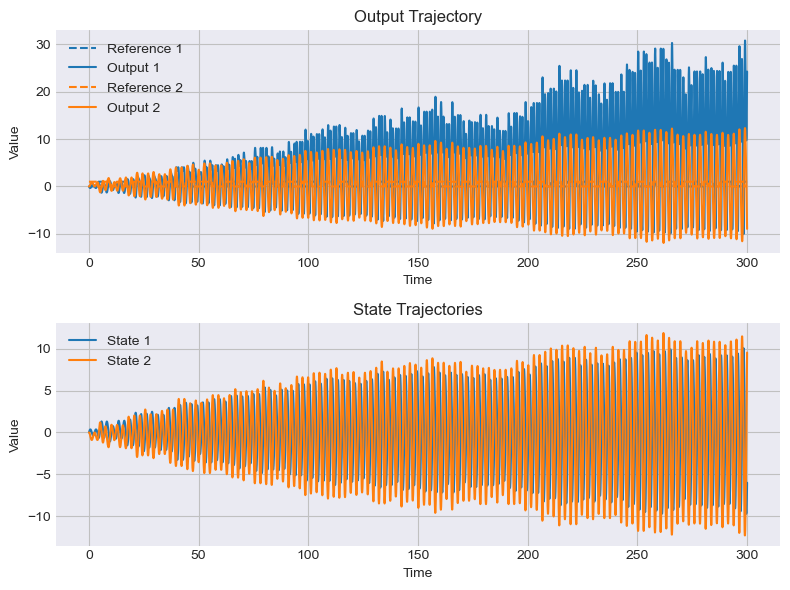

In [5]:
init = np.zeros((2,1))
o = G.simulate(ref, t, initial_states=init)

## Define Neural Controller

In [6]:
layer1 = Dense(input_size=4, output_size=5,activation='leaky_relu')
layer1.weight /= 5
layer2 = Dense(input_size=5, output_size=2, activation='linear', L1_coe=1e-5)  # Regularization to reduce control effort
layer2.weight /= 2
model = Online_NN_section([layer1, layer2])
model.summary()


 ****************************** model summary ****************************** 

layer 1:
	<class 'layers.Dense.Dense_network.Dense'>
	activation function: leaky_relu
	batch size: 32
	input size: 4
	output size: 5
	number of parameters: 25
	number of trainable parameters: 25
	number of non trainable parameters: 0
	--------------------------------------------------
layer 2:
	<class 'layers.Dense.Dense_network.Dense'>
	activation function: linear
	batch size: 32
	input size: 5
	output size: 2
	number of parameters: 12
	number of trainable parameters: 12
	number of non trainable parameters: 0
	--------------------------------------------------
total number of parameters: 37
	total number of trainable parameters: 37
	total number of non trainable parameters: 0
	

## Examine open loop before training
please note that if any numericals occur. if you encounter any large values, rebuild controller again with a less gain. alternatively, reduce sampling time if possible

In [7]:
closloop = NINC_close_loop(controller=model, open_loop_system=G, n_delay=1)

Closed-loop system implementation was successful.



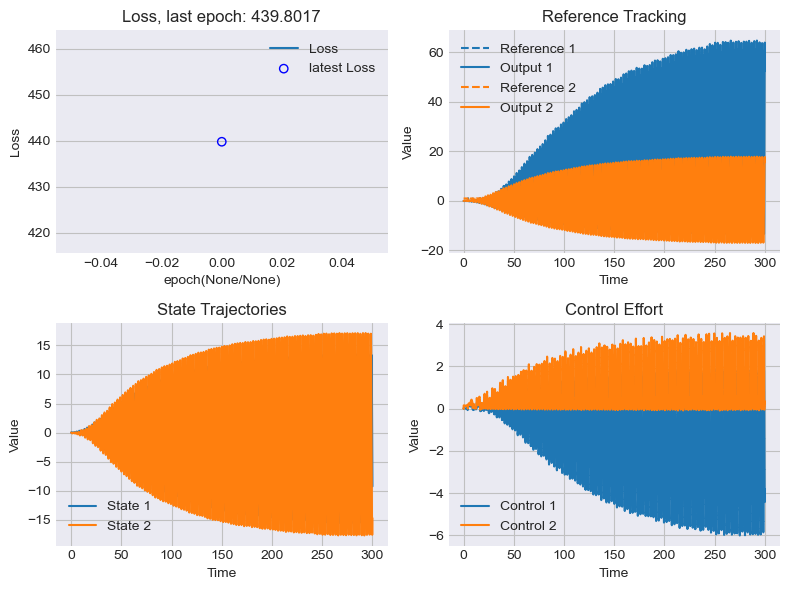

In [8]:
closloop.reset_memory()
x = closloop.simulate(ref, t, plot=True)

## Reset initial states

In [9]:
closloop.reset_memory()

## Train neural controller
instead of any epoch larger than 1, you can increase end_time like end_time*epoch

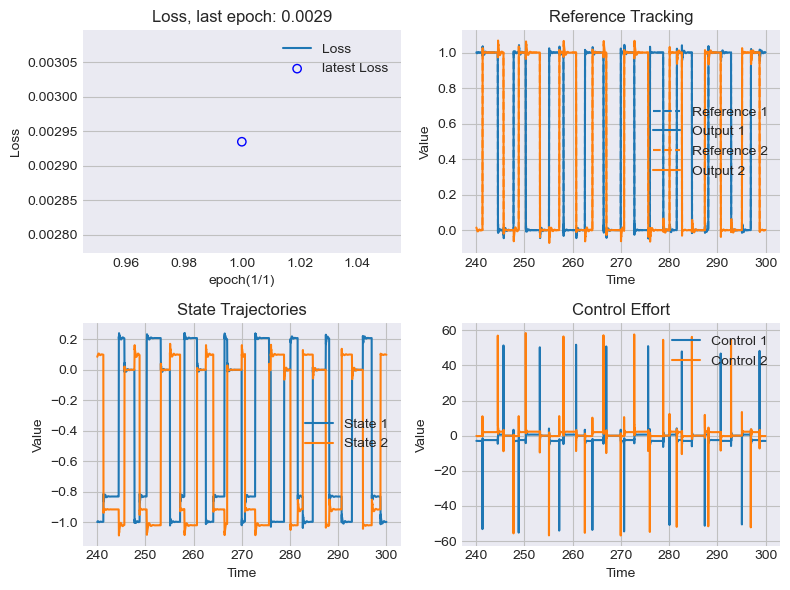

In [10]:
closloop.G.perturb = 1e-6
history = closloop.online_train(ref, t, MSE(), learning_rate=1e-2, method='Adam', epoch=1, time_percent=0.2, fig_size=(8,6))

## Test neural controller on a different signal

In [11]:
end_time = 3.0  # 10 seconds
min_time = 0.5  # Minimum toggle interval
max_time = 2.0  # Maximum toggle interval
sampling_time = 0.001  # Sampling time step

t, ref = randomized_pulse_generator(end_time, min_time, max_time, sampling_time, 2)

### Discrete time simulation

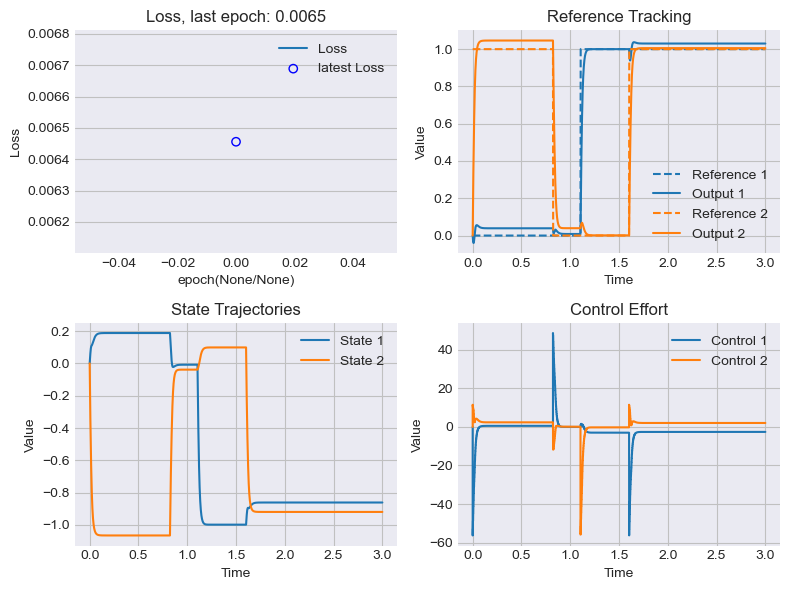

In [12]:
closloop.reset_memory()
o = closloop.simulate(ref, t, plot=True, fig_size1=(12,6))

### Continuous time simulation
By default, we choose 3 points between each \( t \) element, or **samp_per_dt** represents the number of time points between each sampling time of time vector. The sampling_time is used for controller updates and should be the same as it was during training.

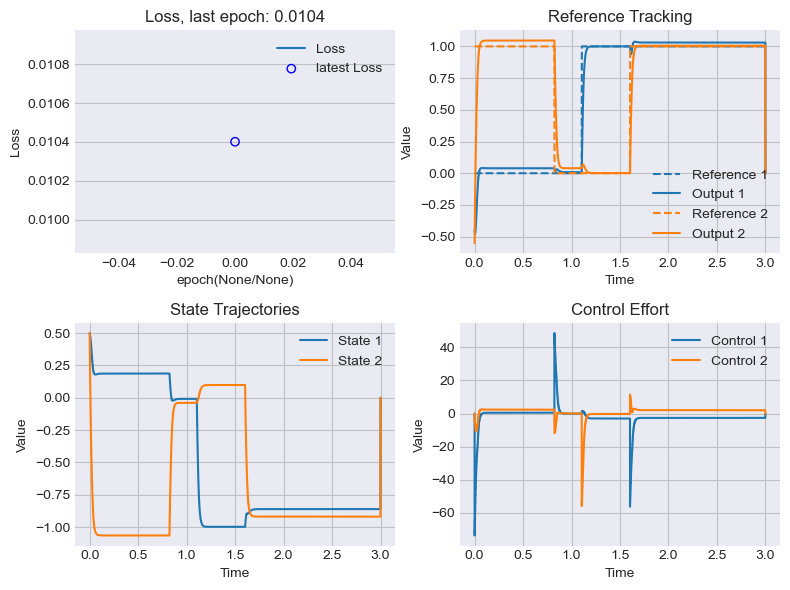

In [16]:
o = closloop.continuous_simulation(
        t, 
        ref, 
        sampling_time, 
        samp_per_dt = 3,
        initial_condition = 0.5 * np.ones(closloop.G.state.shape))